In [1]:
import importlib
import pandas as pd
import xarray as xr
import numpy as np
import sys
import warnings
from scipy import signal 
import glob as glob

from ecpaper_utils import bootstrap_utils as boot
from ecpaper_utils import linfit_utils as linfit

importlib.reload(boot)
importlib.reload(linfit)

warnings.filterwarnings('ignore')

In [2]:
cmip5models=pd.read_csv("../../DATASORT/cmip5csvinfo.csv")
cmip6models=pd.read_csv("../../DATASORT/cmip6csvinfo.csv")

In [3]:
calp_path="/project/cas/islas/python_savs/ecpaper2020/DATASORT/CALP/"

#### read processed Large Ensemble data into one Dataset

In [4]:
le_models = ['CanESM2','CESM1-CAM5','CSIRO-Mk3-6-0','GFDL-CM3','MPI-ESM']
le_dat_past = []
le_dat_future = [] 

for le in le_models:
    print(le)
    ## past data
    dsp = xr.open_dataset(calp_path+"calpdata_"+le+"_past.nc")
    dsp = dsp.assign_coords({"Model": le})
    
    ## future data
    dsf = xr.open_dataset(calp_path+"calpdata_"+le+"_future.nc")
    dsf = dsf.assign_coords({"Model": le})
    
    ## detrend nino34 and calp timeseries
    dsp["nino34p_detrend"] = xr.apply_ufunc(signal.detrend, dsp["nino34p"])
    dsp["calpp_detrend"] = xr.apply_ufunc(signal.detrend, dsp["calpp"])
    
    dsf["nino34f_detrend"] = xr.apply_ufunc(signal.detrend, dsf["nino34f"])
    dsf["calpf_detrend"] = xr.apply_ufunc(signal.detrend, dsf["calpf"])
    
    ## calculate future CA precip trend 2006-2099
    dsf["ca_p_trend"] = xr.apply_ufunc(linfit.compute_slope,
                                      dsf["calpf"],
                                      vectorize=True, 
                                      input_core_dims=[['time']])*86400*100 ## convert to mm/day per 100y
    
    ## convert to datetime64
    if (type(dsp.indexes['time']) != pd.core.indexes.datetimes.DatetimeIndex):
        dsp["time"] = dsp.indexes["time"].to_datetimeindex()
        dsf["time"] = dsf.indexes["time"].to_datetimeindex()
    le_dat_past.append(dsp)
    le_dat_future.append(dsf)

CanESM2
CESM1-CAM5
CSIRO-Mk3-6-0
GFDL-CM3
MPI-ESM


In [5]:
le_dat_past = xr.concat(le_dat_past, dim = "Model") ## LEs that have <100 members will have some nans - drop later with dropna
le_dat_future = xr.concat(le_dat_future, dim = "Model")

#### calculate nino34_cap correlations and mean CA precip trend for LEs

In [6]:
le_corr_past = []
le_corr_future = []
le_mean_captrend = []

for le in le_models: 
    print(le)
    le_corr_past.append(xr.corr(le_dat_past.sel(Model = le).dropna(dim = "Member")["nino34p_detrend"], 
                           le_dat_past.sel(Model = le).dropna(dim = "Member")["calpp_detrend"]).values)
    le_corr_future.append(xr.corr(le_dat_future.sel(Model = le).dropna(dim = "Member")["nino34f_detrend"], 
                           le_dat_future.sel(Model = le).dropna(dim = "Member")["calpf_detrend"]).values)
    le_mean_captrend.append(le_dat_future.sel(Model = le).dropna(dim = "Member")["ca_p_trend"].mean().values)


CanESM2
CESM1-CAM5
CSIRO-Mk3-6-0
GFDL-CM3
MPI-ESM


### calculate CMIP5 error estimates

In [7]:
models = cmip5models['Model']
nmodels = models.shape[0]
nboots = 1000

sigx_p = np.zeros(nmodels) 
sigx_f = np.zeros(nmodels) 
sigy = np.zeros(nmodels)
rxy_p = np.zeros(nmodels)
rxy_f = np.zeros(nmodels)

for i, model in enumerate(models):
    nmemp=cmip5models.loc[i, "Nmempast"]
    nmemf=cmip5models.loc[i, "Nmemfuture"]
    
    boots_corr_p = []
    boots_corr_f = []
    boots_ptrend = []
    for j, le in enumerate(le_models):
        ## calculate bootstrapped correlation for past
        b = boot.boot_corr_multimem([le_dat_past.sel(Model = le)["nino34p_detrend"].dropna(dim = "Member"), 
                                     le_dat_past.sel(Model = le)["calpp_detrend"].dropna(dim = "Member")],
                                     nboots, nmemp, seed=3).values
        boots_corr_p.append(b - le_corr_past[j]) ## subtract LE mean value so that LEs can be pooled for np.std calculation
        
        ## bootstrapped correlations for future
        b = boot.boot_corr_multimem([le_dat_future.sel(Model = le)["nino34f_detrend"].dropna(dim = "Member"), 
                                     le_dat_future.sel(Model = le)["calpf_detrend"].dropna(dim = "Member")],
                                     nboots, nmemf, seed=3).values
        boots_corr_f.append(b - le_corr_future[j])
        
        ## bootstrapped mean future CA precip trends 
        b = boot.bootgen_multimem(le_dat_future.sel(Model = le)["ca_p_trend"].dropna(dim = "Member"), 
                                  nmemf, seed=3).values
        boots_ptrend.append(b - le_mean_captrend[j])
        
    boots_corr_p = np.concatenate(boots_corr_p)
    boots_corr_f = np.concatenate(boots_corr_f)
    boots_ptrend = np.concatenate(boots_ptrend)
    
    sigx_p[i] = np.std(boots_corr_p)
    sigx_f[i] = np.std(boots_corr_f)
    sigy[i] = np.std(boots_ptrend)
    
    rxy_p[i] = np.corrcoef(boots_corr_p, boots_ptrend)[0,1]
    rxy_f[i] = np.corrcoef(boots_corr_f, boots_ptrend)[0,1]

In [8]:
error_dat5 = xr.Dataset({'sigx_p': xr.DataArray(sigx_p, coords=[models], dims=["Model"]), 
                       'sigx_f': xr.DataArray(sigx_f, coords=[models], dims=["Model"]), 
                        'sigy': xr.DataArray(sigy, coords=[models], dims=["Model"]), 
                       'rxy_p': xr.DataArray(rxy_p, coords=[models], dims=["Model"]), 
                       'rxy_f': xr.DataArray(rxy_f, coords=[models], dims=["Model"])})

error_dat5.to_netcdf("./DATA/errors_cmip5.nc")

In [9]:
error_dat5

<xarray.Dataset>
Dimensions:  (Model: 37)
Coordinates:
  * Model    (Model) object 'ACCESS1-0' 'ACCESS1-3' ... 'NorESM1-M' 'NorESM1-ME'
Data variables:
    sigx_p   (Model) float64 0.1196 0.1196 0.1196 ... 0.1196 0.1196 0.1196
    sigx_f   (Model) float64 0.09446 0.09446 0.09446 ... 0.09446 0.09446 0.09446
    sigy     (Model) float64 0.5376 0.5376 0.5376 ... 0.5376 0.5376 0.5376
    rxy_p    (Model) float64 -0.04924 -0.04924 -0.04924 ... -0.04924 -0.04924
    rxy_f    (Model) float64 0.09566 0.09566 0.09566 ... 0.09566 0.09566 0.09566

### Calculate error for CMIP6 models

In [9]:
models = cmip6models['Model']
nmodels = models.shape[0]
nboots = 1000

sigx_p = np.zeros(nmodels) 
sigx_f = np.zeros(nmodels) 
sigy = np.zeros(nmodels)
rxy_p = np.zeros(nmodels)
rxy_f = np.zeros(nmodels)

for i, model in enumerate(models):
    nmemp=cmip6models.loc[i, "Nmempast"]
    nmemf=cmip6models.loc[i, "Nmemfuture"]
    
    boots_corr_p = []
    boots_corr_f = []
    boots_ptrend = []
    for j, le in enumerate(le_models):
        ## calculate bootstrapped correlation for past
        b = boot.boot_corr_multimem([le_dat_past.sel(Model = le)["nino34p_detrend"].dropna(dim = "Member"), 
                                                 le_dat_past.sel(Model = le)["calpp_detrend"].dropna(dim = "Member")],
                                                 nboots, nmemp, seed=3).values
        boots_corr_p.append(b - le_corr_past[j]) ## subtract LE mean value so that LEs can be pooled for np.std calculation
        
        ## bootstrapped correlations for future
        b = boot.boot_corr_multimem([le_dat_future.sel(Model = le)["nino34f_detrend"].dropna(dim = "Member"), 
                                                 le_dat_future.sel(Model = le)["calpf_detrend"].dropna(dim = "Member")],
                                                 nboots, nmemf, seed=3).values
        boots_corr_f.append(b - le_corr_future[j])
        
        ## bootstrapped mean future CA precip trends 
        b = boot.bootgen_multimem(le_dat_future.sel(Model = le)["ca_p_trend"].dropna(dim = "Member"), 
                                                    nmemf, seed=3).values
        boots_ptrend.append(b - le_mean_captrend[j])
        
    boots_corr_p = np.concatenate(boots_corr_p)
    boots_corr_f = np.concatenate(boots_corr_f)
    boots_ptrend = np.concatenate(boots_ptrend)
    
    sigx_p[i] = np.std(boots_corr_p)
    sigx_f[i] = np.std(boots_corr_f)
    sigy[i] = np.std(boots_ptrend)
    
    rxy_p[i] = np.corrcoef(boots_corr_p, boots_ptrend)[0,1]
    rxy_f[i] = np.corrcoef(boots_corr_f, boots_ptrend)[0,1]

In [10]:
error_dat6 = xr.Dataset({'sigx_p': xr.DataArray(sigx_p, coords=[models], dims=["Model"]), 
                       'sigx_f': xr.DataArray(sigx_f, coords=[models], dims=["Model"]), 
                        'sigy': xr.DataArray(sigy, coords=[models], dims=["Model"]), 
                       'rxy_p': xr.DataArray(rxy_p, coords=[models], dims=["Model"]), 
                       'rxy_f': xr.DataArray(rxy_f, coords=[models], dims=["Model"])})

error_dat6.to_netcdf("./DATA/errors_cmip6.nc")

In [12]:
error_dat6

<xarray.Dataset>
Dimensions:  (Model: 38)
Coordinates:
  * Model    (Model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    sigx_p   (Model) float64 0.08528 0.06882 0.05339 ... 0.06882 0.1196 0.06055
    sigx_f   (Model) float64 0.09446 0.05373 0.09446 ... 0.09446 0.09446 0.04109
    sigy     (Model) float64 0.5376 0.3146 0.5376 ... 0.5376 0.5376 0.2437
    rxy_p    (Model) float64 -0.0002111 0.001575 0.001304 ... -0.04924 -0.01694
    rxy_f    (Model) float64 0.09566 -0.03473 0.09566 ... 0.09566 -0.01942

### Checking results... 

In [13]:
import matplotlib.pyplot as plt

plot estimated error as a function of the number of ensemble members (for CMIP6): 

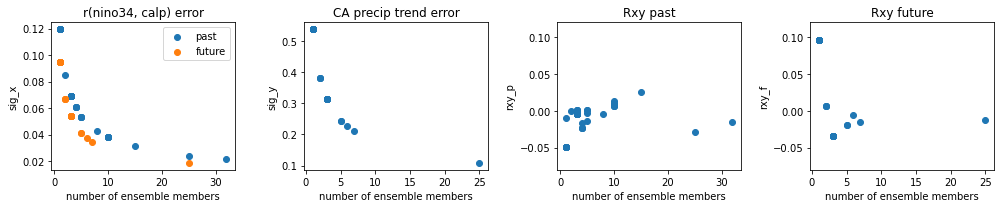

In [14]:
fig = plt.figure(figsize = (14, 3))

ax = fig.add_subplot(141)
ax.scatter(cmip6models["Nmempast"], error_dat6["sigx_p"])
ax.scatter(cmip6models["Nmemfuture"], error_dat6["sigx_f"])
ax.set(xlabel = "number of ensemble members", ylabel = "sig_x", title = "r(nino34, calp) error")
ax.legend(labels = ["past", "future"])

ax = fig.add_subplot(142)
ax.scatter(cmip6models["Nmemfuture"], error_dat6["sigy"])
ax.set(xlabel = "number of ensemble members", ylabel = "sig_y", title = "CA precip trend error") 

ax = fig.add_subplot(143)
ax.scatter(cmip6models["Nmempast"], error_dat6["rxy_p"]) ## different number of ensemble members for x and y, but plot Nmempast
ax.set(xlabel = "number of ensemble members", ylabel = "rxy_p", title = "Rxy past", ylim = (-.08, .12)); 

ax = fig.add_subplot(144)
ax.scatter(cmip6models["Nmemfuture"], error_dat6["rxy_f"])
ax.set(xlabel = "number of ensemble members", ylabel = "rxy_f", title = "Rxy future", ylim = (-.08, .12)); 

plt.tight_layout()

check bootstrapped results above with standard deviations calculated across all ensemble members of individual LEs (should be consistent with the bootstrapped values for the models with only one ensemble member in the plots above): 

In [15]:
## std. dev. of PAST nino34-ca precip correlation across all ensemble members of LEs 
for i in le_models: 
    print(np.round(np.std(le_dat_past["cor_nino34_calp"].sel(Model = i).dropna(dim = "Member").values), 4), 
          i)

0.0953 CESM1-CAM5
0.1269 CSIRO-Mk3-6-0
0.1087 CanESM2
0.1039 GFDL-CM3
0.1417 MPI-ESM


In [16]:
## std. dev. of FUTURE nino34-ca precip correlation across all ensemble members of LEs 
for i in le_models: 
    print(np.round(np.std(xr.corr(le_dat_future.sel(Model = i).dropna(dim = "Member")["nino34f_detrend"], 
            le_dat_future.sel(Model = i).dropna(dim = "Member")["calpf_detrend"], dim = ["time"])).values, 4), 
         i)

0.0677 CESM1-CAM5
0.1116 CSIRO-Mk3-6-0
0.0724 CanESM2
0.0942 GFDL-CM3
0.1165 MPI-ESM


In [17]:
## std. dev. of FUTURE CA precip trend across all ensemble members of LEs 
for i in le_models: 
    print(np.round(np.std(le_dat_future["ca_p_trend"].sel(Model = i).dropna(dim = "Member").values), 4), 
          i)

0.4004 CESM1-CAM5
0.5521 CSIRO-Mk3-6-0
0.6273 CanESM2
0.5112 GFDL-CM3
0.5737 MPI-ESM
